In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

from copy import deepcopy

## 1 Prepare background and foreground images

In [3]:
background = cv2.imread('../data/images/room.jpg', 0)

# bottom-left, top-left, bottom-right, top-right
background_points = np.array([[385, 538],
                              [300, 538],
                              [388, 689],
                              [294, 689]], dtype=np.float32)
background_points = np.roll(background_points, 0, axis=1)

foreground = cv2.imread('../data/images/building2.jpg', 0)
foreground_points = np.array([[foreground.shape[0], 0],
                              [0, 0],
                              [foreground.shape[0], foreground.shape[1]],
                              [0, foreground.shape[1]]], dtype=np.float32)
foreground_points = np.roll(foreground_points, 1, axis=1)

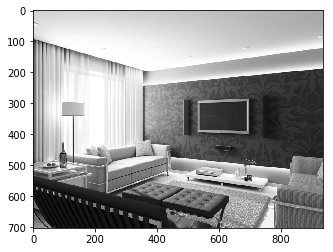

In [6]:
plt.imshow(background, cmap='gray')

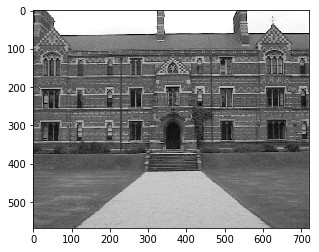

In [5]:
plt.imshow(foreground, cmap='gray')

## 2 Compute homography

In [7]:
def homography(points1, points1_indices, points2, points2_indices, num_points=4, min_num_points=4):
    """
    Computes homography matrix for given two sets of points

    :param points1: First point set
    :param points1_indices: First point set indices
    :param points2: Second point set
    :param points2_indices: Second Point set indices
    :param num_points: Number of points to use for calculating homography
    :param min_num_points: Minimum number of points required (Degree of freedom)
    :return: A 3x3 normalized homography matrix
    """
    assert num_points >= min_num_points

    # build A matrix
    a_matrix = np.zeros((num_points * 2, 9))
    idx = 0
    for i, j in zip(points1_indices, points2_indices):
        a_matrix[idx, :] = np.array([-points1[i, 0, 0], -points1[i, 0, 1], -1,
                                     0, 0, 0,
                                     points2[j, 0, 0] * points1[i, 0, 0],
                                     points2[j, 0, 0] * points1[i, 0, 1],
                                     points2[j, 0, 0]])
        idx += 1
        a_matrix[idx, :] = np.array([0, 0, 0,
                                     -points1[i, 0, 0], -points1[i, 0, 1], -1,
                                     points2[j, 0, 1] * points1[i, 0, 0],
                                     points2[j, 0, 1] * points1[i, 0, 1],
                                     points2[j, 0, 1]])
        idx += 1

    u, s, v = np.linalg.svd(a_matrix)
    h_unnormalized = v[8].reshape(3, 3)
    h = (1 / h_unnormalized.flatten()[8]) * h_unnormalized

    # eig = np.linalg.eig(a_matrix.T.dot(a_matrix))
    # # smallest_idx = eig[0].argmin()
    # h_ = eig[1][-1].reshape(3, 3)
    # h = (1 / h_.flatten()[8]) * h_
    return h


background_points = background_points.reshape((-1, 1, 2))
foreground_points = foreground_points.reshape((-1, 1, 2))
MIN_NUM_POINTS = 4
points1_indices = random.sample(list(range(len(background_points))), MIN_NUM_POINTS)
h_matrix = homography(foreground_points, np.arange(4), background_points, np.arange(4))

## 3 Warp

In [9]:
im1reg = cv2.warpPerspective(foreground, h_matrix, background.shape)

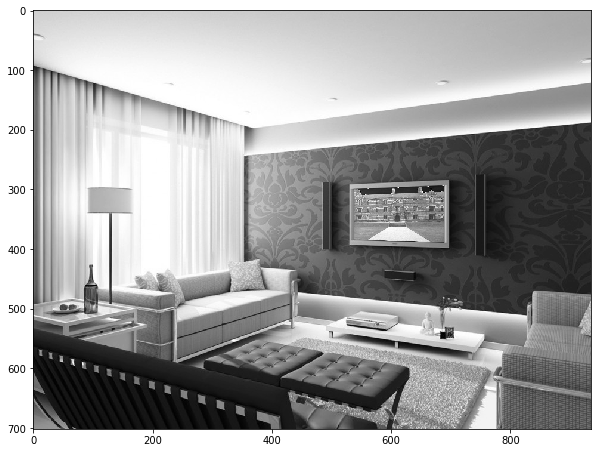

In [10]:
plt.figure(figsize=(10, 10))
vis = deepcopy(background)
vis[im1reg.T.nonzero()] = 0
plt.imshow(im1reg.T + background, cmap='gray')